# Video Classification with VideoSwin


In this notebook, we will show how to fine-tune [**VideoSwin**](https://arxiv.org/abs/2106.13230) model for a classification task. The official release is in [`torch`](https://github.com/SwinTransformer/Video-Swin-Transformer). This notebook is the [`keras`](https://github.com/innat/VideoSwin) reimplementation.


## VideoSwin

**VideoSwin** is a pure transformer based video modeling algorithm, attained top accuracy on the major video recognition benchmarks. In this model, the author advocates an inductive bias of locality in video transformers, which leads to a better speed-accuracy trade-off compared to previous approaches which compute self-attention globally even with spatial-temporal factorization. The locality of the proposed video architecture is realized by adapting the [**Swin Transformer**](https://arxiv.org/abs/2103.14030) designed for the image domain, while continuing to leverage the power of pre-trained image models.


In this quick demonstration, we will show how to fine-tune a custom dataset with **VideoSwin** models. We will be using a videoswin as a backbone and add a custom head on top of it.   

<td>
<a target="_blank" href="https://colab.research.google.com/drive/1Q7A700MEI10UomikqjQJANWyFZktJCT-?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

<td>
<a target="_blank" href="https://huggingface.co/spaces/innat/VideoSwin"><img src="https://user-images.githubusercontent.com/17668390/176064420-46cbf547-0d17-4438-a791-d23e17eff5a9.png" />Try on Gradio</a>
</td>

## Dataset

This is where you can use your own data. For demonstration purpose, we have created a sub-set of Kintetics dataset with `5` categories to represent a custom dataset. Here is the link of [KineticsTop5](https://huggingface.co/datasets/innat/KineticsTop5) datast. You can choose your own dataset and dataloader.





In [1]:
!pip install huggingface_hub decord -q

ERROR: Operation cancelled by user
^C


In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader

from huggingface_hub import hf_hub_download
from mpl_toolkits.axes_grid1 import ImageGrid
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DEVICE = 'GPU' # 'GPU', 'TPU'

/home/siamai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from videoswin import VideoSwinB

# model = VideoSwinB(
#     include_top=False,
#     input_shape=(32, 224, 224, 3)
# )


2025-06-19 04:04:08.994485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 04:04:09.073096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 04:04:10.750926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-06-19 04:04:11.769267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one N

In [ ]:
if DEVICE == 'TPU':
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    keras.mixed_precision.set_global_policy("mixed_bfloat16")
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    [tf.config.experimental.set_memory_growth(pd, True) for pd in physical_devices]
    strategy = tf.distribute.MirroredStrategy()

HOME = os.getcwd()
tf.__version__, HOME, strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


('2.16.1',
 '/home/siamai/data/Penguin/week7',
 <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy at 0x7f4f082acb80>)

## Utils

In [3]:
def denormalize(z):
    mean = np.array([123.675, 116.28, 103.53])
    std = np.array([58.395, 57.12, 57.375])
    x = (z * std) + mean
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x


def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        # ax.imshow(img.numpy().astype('uint8'))
    # for ax, img in zip(grid, denormalize(seq)):
        ax.imshow(img.astype('uint8'))
        ax.set_axis_off()
    plt.show()
    return

## Data



In [4]:
from sklearn.model_selection import train_test_split

def create_multilabel_dataframe(csv_path, video_folder):
    df = pd.read_csv(csv_path)
    df["video_path"] = df["clip"].apply(lambda x: os.path.join(video_folder, x))
    df = df.drop(columns=["clip"])
    return df

csv_path = "/home/siamai/data/chuniji/Tryweek7swin/label_clips.csv"
video_folder = "/home/siamai/data/chuniji/Tryweek7swin/videossliced"

full_df = create_multilabel_dataframe(csv_path, video_folder)

train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")


Train size: 295 | Test size: 74


In [ ]:
# train_set = f'/data/train'
# test_set = f'/data/test'
# class_folders = os.listdir(train_set)
# label2id = {label:i for i, label in enumerate(class_folders)}
# id2label = {v:k for k, v in label2id.items()}
# id2label

In [5]:
gesture_labels = [
    "Advancing", "Retreating", "Enclosing", "Spreading", "Rising", "Descending",
    "Directing", "Indirecting", "Increasing Pressure", "Decreasing Pressure",
    "Acceleration", "Decelerating"
]
num_labels = len(gesture_labels)


In [ ]:
# def create_multilabel_dataframe(csv_path, video_folder):
#     df = pd.read_csv(csv_path)
#     df['video_path'] = df['clip'].apply(lambda x: os.path.join(video_folder, x))
#     return df



# train_video_folder = "/home/siamai/data/chuniji/Tryweek7swin/videossliced"
# train_csv = "/home/siamai/data/chuniji/Tryweek7swin/label_clips.csv"

# train_df = create_multilabel_dataframe(train_csv, train_video_folder)



In [16]:
print(train_df.head())


     Advancing  Retreating  Enclosing  Spreading  Rising  Descending  \
344          0           0          0          1       0           0   
192          0           1          0          0       0           0   
75           0           0          0          0       0           0   
84           0           0          1          0       0           0   
357          0           0          1          0       0           0   

     Directing  Indirecting  Increasing Pressure  Decreasing Pressure  \
344          0            0                    1                    0   
192          1            0                    1                    0   
75           0            0                    0                    0   
84           0            0                    1                    0   
357          0            1                    1                    0   

     Acceleration  Decelerating  \
344             1             0   
192             1             0   
75              0      

In [7]:
test_df.head()

,Advancing,Retreating,Enclosing,Spreading,Rising,Descending,Directing,Indirecting,Increasing Pressure,Decreasing Pressure,Acceleration,Decelerating,video_path
326,1,0,1,0,0,0,1,0,1,0,1,0,/home/siamai/data/chuniji/Tryweek7swin/videoss...
33,0,0,1,0,1,0,0,0,1,0,0,1,/home/siamai/data/chuniji/Tryweek7swin/videoss...
15,0,0,1,0,0,0,0,0,0,1,0,1,/home/siamai/data/chuniji/Tryweek7swin/videoss...
345,0,0,0,1,0,0,0,0,0,0,0,0,/home/siamai/data/chuniji/Tryweek7swin/videoss...
57,0,0,1,0,0,0,0,0,1,0,0,1,/home/siamai/data/chuniji/Tryweek7swin/videoss...


# Data Loader

Reading the video data from dataloader in training time can be challenging. We can leverage [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format, but due to the cost of disk space, we will skip that. For now, we will be using [`decord`](https://github.com/dmlc/decord) for video reader. It supports both GPUs and TPUs.



In [6]:
input_size=224
num_frame=32
sampling_rate=2
batch_size=2 * strategy.num_replicas_in_sync

In [7]:
def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

def load_video(file_path, label_vec):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([None, None, None, 3])
    return video, tf.cast(label_vec, dtype=tf.float32)


The raw **Kinetics** data comes with variable size of **input frame** and **frame size**. We will resize the video to the target shape (i.e. `224`). For **VideoSwin** model, the clip length is `32`. We will use frame rate `2` which is the stride or step from a frame to next frame. We will also take `1` clip from a video. However, in literature for evaluation, it's common to take `num_clips > 1` from each clip and average the results for final prediction For **VideoSwin**, check the official [note](https://github.com/SwinTransformer/Video-Swin-Transformer/blob/db018fb8896251711791386bbd2127562fd8d6a6/configs/recognition/swin/swin_tiny_patch244_window877_kinetics400_1k.py#L48-L52) on this. But here for simplicity cause, we will skip that.


Sampling strategy for frame selection is another important factor which might need another attention. It can significantly differs the reported scores. In this notebook, we will be using [uniform sampling](https://gist.github.com/innat/205075992360d8d7a241c7f1013866a8) for frame selection.

In [8]:
def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples-1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips*num_frames, crop_size, crop_size, 3]
    )
    return video


In [9]:
processing_model = keras.Sequential(
    [
        layers.Normalization(
            mean=[123.675, 116.28, 103.53],
            variance=[np.square(58.395), np.square(57.12), np.square(57.375)]
        )
    ]
)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['video_path'].values, df[gesture_labels].values.astype(np.float32))
    )
    ds = ds.repeat()
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x, y: (clip_generator(x, num_frame, sampling_rate, num_clips=1), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds



In [10]:
train_ds = create_dataloader(train_df, batch_size, shuffle=True)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

In [11]:
def check_exclusive_pairs(df, pairs):
    for idx1, idx2 in pairs:
        invalid = df[(df[gesture_labels[idx1]] == 1) & (df[gesture_labels[idx2]] == 1)]
        if not invalid.empty:
            print(f"Found invalid pairs for {gesture_labels[idx1]} and {gesture_labels[idx2]}")
            print(invalid)

exclusive_pairs = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11)]
dfd = pd.read_csv("/home/siamai/data/chuniji/Tryweek7swin/label_clips.csv")
check_exclusive_pairs(dfd, exclusive_pairs)


**Visualize**

In [12]:
temp_ds = create_dataloader(
    test_df, 8, shuffle=False
)
x, y = next(iter(temp_ds))
x.shape, y

(TensorShape([8, 32, 224, 224, 3]),
 <tf.Tensor: shape=(8, 12), dtype=float32, numpy=
 array([[1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]], dtype=float32)>)

In [13]:
id2label = {i: label for i, label in enumerate(gesture_labels)}

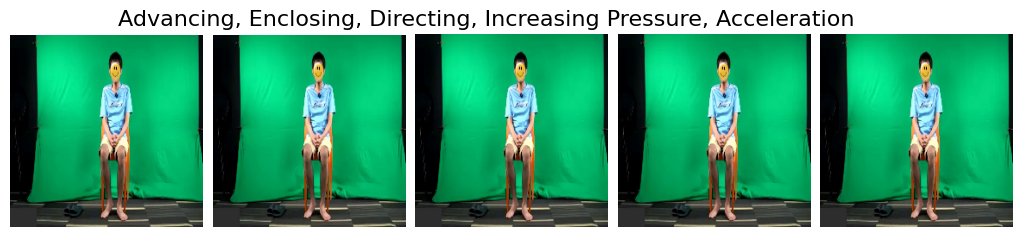

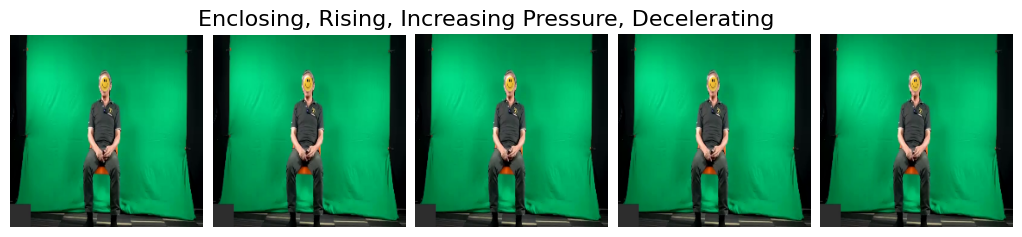

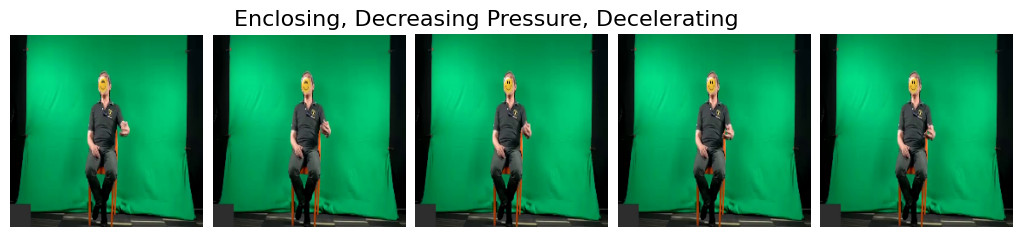

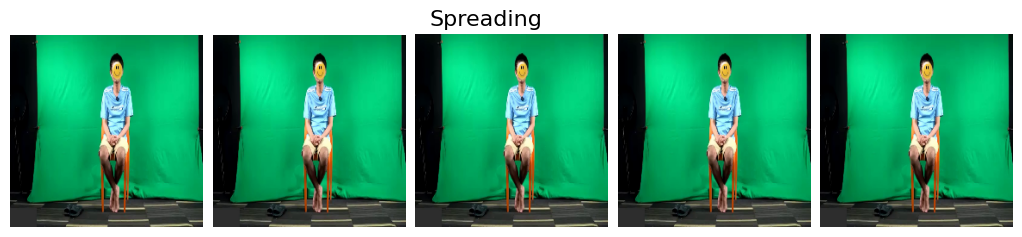

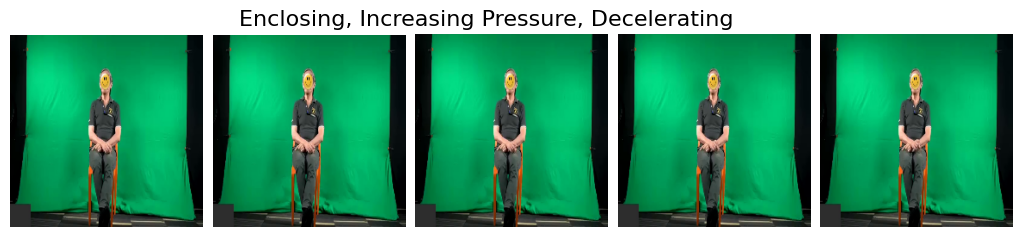

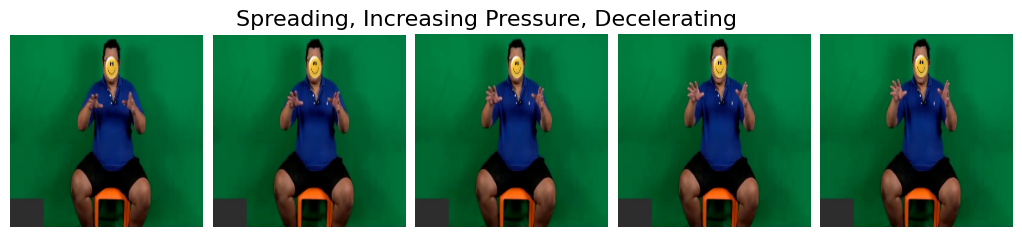

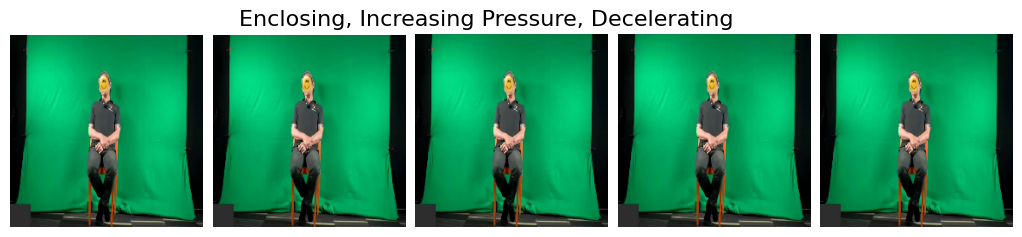

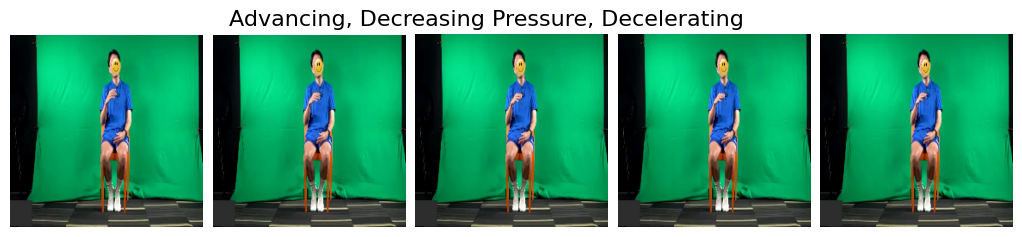

In [14]:
for i in range(len(x)):
    label_ids = tf.where(y[i] > 0)[:, 0].numpy()
    label_names = [id2label[id] for id in label_ids]
    title = ", ".join(label_names) if label_names else "No label"
    show_sequence(x.numpy()[i], sample=5, title=title)


In [17]:
print(x.dtype)
print(tf.reduce_min(x), tf.reduce_max(x))


<dtype: 'float32'>
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(255.0, shape=(), dtype=float32)


# Model

As mentioned, we are using a custom **Kinetics-5** dataset. We will be using **VideoSwin** model with **Something-Something-V2** pretrained checkpoint. We will freeze the backbone and only train the custom head for downstream task.

In [ ]:
# backbone_name = "TFVideoSwinB_SSV2_K400_P244_W1677_32x224"

In [15]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("ตั้งค่า GPU memory growth เรียบร้อย")
    except RuntimeError as e:
        print(e)


In [ ]:
# from tensorflow.keras import layers, models, metrics, optimizers
# from tensorflow.keras.mixed_precision import set_global_policy
# from videoswin import VideoSwinB
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# import decord
# import os
# import keras

# # ตั้งค่า mixed precision
# set_global_policy('mixed_float16')

# # Custom loss
# def exclusive_pair_loss(y_true, y_pred):
#     bce_loss = keras.losses.binary_crossentropy(y_true, y_pred)
#     exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
#     pair_sums = tf.gather(y_pred, exclusive_pairs, axis=1)
#     penalty = tf.reduce_mean(tf.maximum(0.0, tf.reduce_sum(pair_sums, axis=2) - 1.0))
#     return bce_loss + penalty * 0.2

# # Custom metric
# def exclusive_pair_accuracy(y_true, y_pred):
#     y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
#     exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
#     pair_preds = tf.gather(y_pred_binary, exclusive_pairs, axis=1)
#     invalid = tf.reduce_any(tf.reduce_sum(pair_preds, axis=2) > 1, axis=1)
#     valid = tf.cast(~invalid, tf.float32)
#     return tf.reduce_mean(valid)

# # Data augmentation
# def augment_video(video, label):
#     def augment_single_frame(frame):
#         frame = tf.image.random_flip_left_right(frame)
#         frame = tf.image.random_brightness(frame, max_delta=0.3)
#         frame = tf.image.random_contrast(frame, lower=0.7, upper=1.3)
#         frame = tf.image.random_crop(frame, size=[input_size-30, input_size-30, 3])
#         frame = tf.image.resize(frame, [input_size, input_size])
#         return frame

#     minority_class_indices = [4, 5, 7, 9]
#     selected_labels = tf.gather(label, minority_class_indices)
#     has_minority_class = tf.reduce_any(selected_labels > 0.0)

#     video = tf.cond(
#         has_minority_class,
#         lambda: tf.vectorized_map(augment_single_frame, video),
#         lambda: video,
#         name="augment_cond"
#     )
    
#     return video, label

# # Preprocess วิดีโอ
# def preprocess_video(file_path, output_dir, input_size=160, num_frame=32, sampling_rate=2):
#     vr = decord.VideoReader(file_path)
#     frames = vr.get_batch(range(0, len(vr), sampling_rate)).asnumpy()[:num_frame]
#     frames = tf.image.resize(frames, [input_size, input_size]).numpy()
#     output_path = os.path.join(output_dir, os.path.basename(file_path) + '.npy')
#     np.save(output_path, frames)
#     return output_path

# output_dir = '/home/siamai/data/chuniji/Tryweek7swin/prepro'
# os.makedirs(output_dir, exist_ok=True)

# # สร้างคอลัมน์ preprocessed_path
# train_df['preprocessed_path'] = train_df['video_path'].apply(
#     lambda x: preprocess_video(x, output_dir)
# )
# test_df['preprocessed_path'] = test_df['video_path'].apply(
#     lambda x: preprocess_video(x, output_dir)
# )

# # สร้างโมเดล
# batch_size = 2 * strategy.num_replicas_in_sync
# input_size = 160
# num_frame = 32
# num_labels = 12
# gesture_labels = [
#     'Advancing', 'Retreating', 'Enclosing', 'Spreading', 'Rising', 'Descending',
#     'Directing', 'Indirecting', 'Increasing Pressure', 'Decreasing Pressure',
#     'Acceleration', 'Decelerating'
# ]

# with strategy.scope():
#     backbone = VideoSwinB(include_top=False, input_shape=(num_frame, input_size, input_size, 3))
#     backbone.load_weights('/home/siamai/data/chuniji/Tryweek7swin/videoswin_base_something_something_v2_classifier.weights.h5', skip_mismatch=True)
    
#     backbone.trainable = False
#     for layer in backbone.layers[-10:]:
#         layer.trainable = True
    
#     model = models.Sequential([
#         backbone,
#         layers.GlobalAveragePooling3D(),
#         layers.Dropout(0.5),
#         layers.Dense(num_labels, activation="sigmoid", dtype='float32')
#     ])
    
#     lr_schedule = keras.optimizers.schedules.CosineDecay(
#         initial_learning_rate=5e-4, decay_steps=1000, warmup_target=1e-3, warmup_steps=100
#     )
#     model.compile(
#         optimizer=optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
#         loss=exclusive_pair_loss,
#         metrics=[
#             metrics.BinaryAccuracy(name="accuracy"),
#             metrics.Precision(name="precision"),
#             metrics.Recall(name="recall"),
#             metrics.AUC(name="auc"),
#             metrics.F1Score(name="f1_score", average="micro"),
#             exclusive_pair_accuracy
#         ]
#     )

# # สร้าง dataset
# def create_dataset(df, path_column='preprocessed_path'):
#     dataset = tf.data.Dataset.from_tensor_slices(
#         (df[path_column].values, df[gesture_labels].values)
#     )
#     return dataset

# train_ds = create_dataset(train_df)
# test_ds = create_dataset(test_df)

# # Optimize data pipeline
# def load_video(file_path, label_vec):
#     video = tf.numpy_function(
#         func=lambda x: np.load(x.decode('utf-8')).astype(np.float32),
#         inp=[file_path],
#         Tout=tf.float32
#     )
#     video.set_shape([num_frame, input_size, input_size, 3])
#     label_vec = tf.ensure_shape(label_vec, [num_labels])
#     return video, tf.cast(label_vec, dtype=tf.float32)

# train_ds = train_ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.map(augment_video, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# # ตรวจสอบ shape
# for x, y in train_ds.take(1):
#     print("Video shape:", x.shape, "Label shape:", y.shape)

# # Class weights
# class_counts = train_df[gesture_labels].sum().values
# class_weights = {i: len(train_df) / (num_labels * class_counts[i]) for i in range(len(gesture_labels))}
# print("Class Weights:", class_weights)

# # ฝึกโมเดล
# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
#     epochs=2,
#     class_weight=class_weights,
#     callbacks=[
#         keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
#     ]
# )

# # ประเมินผล
# from sklearn.metrics import classification_report
# def enforce_exclusive_pairs(y_pred, pairs):
#     y_pred = tf.convert_to_tensor(y_pred)
#     exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
#     for (idx1, idx2) in pairs:
#         max_val = tf.maximum(y_pred[:, idx1], y_pred[:, idx2])
#         y_pred = tf.where(y_pred[:, idx1] > y_pred[:, idx2], 
#                           tf.concat([y_pred[:, :idx1], [max_val], [0.0], y_pred[:, idx2+1:]], axis=1),
#                           tf.concat([y_pred[:, :idx1], [0.0], [max_val], y_pred[:, idx2+1:]], axis=1))
#     return y_pred

# y_true, y_pred = [], []
# for x, y in test_ds.take(len(test_df) // batch_size):
#     y_pred.append(enforce_exclusive_pairs(model.predict(x), exclusive_pairs))
#     y_true.append(y.numpy())
# y_true = np.concatenate(y_true)
# y_pred = np.concatenate(y_pred)
# thresholds = [0.3, 0.5, 0.7]
# for thresh in thresholds:
#     print(f"Threshold: {thresh}")
#     print(classification_report(y_true, y_pred > thresh, target_names=gesture_labels))

Video shape: (2, 32, 160, 160, 3) Label shape: (2, 12)
Class Weights: {0: 0.5121527777777778, 1: 0.47275641025641024, 2: 0.16954022988505746, 3: 0.26721014492753625, 4: 1.755952380952381, 5: 0.8779761904761905, 6: 0.15269151138716355, 7: 0.5587121212121212, 8: 0.10285913528591353, 9: 0.5230496453900709, 10: 0.12938596491228072, 11: 0.25877192982456143}
Epoch 1/2
  4/147 ━━━━━━━━━━━━━━━━━━━━ 58:21 24s/step - accuracy: 0.4635 - auc: 0.4641 - exclusive_pair_accuracy: 0.1979 - f1_score: 0.0000e+00 - loss: 0.4508 - precision: 0.1380 - recall: 0.2143     

In [16]:
from tensorflow.keras import layers, models, metrics, optimizers
# from videoswin import VideoSwinB
import tensorflow as tf
import numpy as np


def exclusive_pair_loss(y_true, y_pred):
    bce_loss = keras.losses.binary_crossentropy(y_true, y_pred)
    exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
    pair_sums = tf.gather(y_pred, exclusive_pairs, axis=1)  # Shape: [batch, 6, 2]
    penalty = tf.reduce_mean(tf.maximum(0.0, tf.reduce_sum(pair_sums, axis=2) - 1.0))
    return bce_loss + penalty * 0.2

def exclusive_pair_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
    pair_preds = tf.gather(y_pred_binary, exclusive_pairs, axis=1)  # Shape: [batch, 6, 2]
    invalid = tf.reduce_any(tf.reduce_sum(pair_preds, axis=2) > 1, axis=1)
    valid = tf.cast(~invalid, tf.float32)
    return tf.reduce_mean(valid)

ADD WEIGHT

In [18]:
from tensorflow.keras import layers, models, metrics, optimizers, callbacks
from videoswin import VideoSwinB
import tensorflow as tf
import numpy as np

In [19]:
def weighted_exclusive_pair_loss(class_weights):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights = tf.reduce_sum(class_weights * y_true, axis=1)  # Weight only positive labels
        weighted_bce = bce * weights[:, tf.newaxis]

        # Add penalty for exclusive pairs
        exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)
        pair_sums = tf.gather(y_pred, exclusive_pairs, axis=1)  # [batch, 6, 2]
        penalty = tf.reduce_mean(tf.maximum(0.0, tf.reduce_sum(pair_sums, axis=2) - 1.0))

        return tf.reduce_mean(weighted_bce) + 0.2 * penalty
    return loss

In [20]:
class ExclusivePairAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="exclusive_pair_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")
        self.exclusive_pairs = tf.constant([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
        pair_preds = tf.gather(y_pred_binary, self.exclusive_pairs, axis=1)
        invalid = tf.reduce_any(tf.reduce_sum(pair_preds, axis=2) > 1, axis=1)
        valid = tf.cast(~invalid, tf.float32)
        self.count.assign_add(tf.reduce_sum(valid))
        self.total.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.count / (self.total + 1e-6)

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

In [21]:
# ----------- Backbone Model and Head -----------
with strategy.scope():
    backbone = VideoSwinB(include_top=False, input_shape=(32, 224, 224, 3))
    backbone.load_weights('/home/siamai/data/chuniji/Tryweek7swin/videoswin_base_something_something_v2_classifier.weights.h5', skip_mismatch=True)

    # Fine-tune only last few blocks
    backbone.trainable = False
    for layer in backbone.layers[-20:]:
        layer.trainable = True

    inputs = layers.Input(shape=(32, 224, 224, 3))
    x = backbone(inputs)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_labels, activation='sigmoid', dtype='float32')(x)
    model = models.Model(inputs, outputs)

    # --------- Class Weights ----------
    class_counts = train_df[gesture_labels].sum().values
    class_weights_array = len(train_df) / (num_labels * class_counts)
    # Example tweak
    weights = np.log1p(len(train_df) / (class_counts + 1e-6))
    class_weights_tensor = tf.constant(weights / weights.sum(), dtype=tf.float32)


    # --------- Compile Model ----------
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=[
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
            metrics.F1Score(name="f1_score", average="macro"),
            ExclusivePairAccuracy()
        ]
    )

In [22]:
# --------- Train ---------
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(test_df) // batch_size,
    epochs=2,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
    ]
)

Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 6317s 43s/step - accuracy: 0.6903 - auc: 0.6902 - exclusive_pair_accuracy: 0.7367 - f1_score: 0.1114 - loss: 0.7890 - precision: 0.5107 - recall: 0.5028 - val_accuracy: 0.7241 - val_auc: 0.6971 - val_exclusive_pair_accuracy: 1.0000 - val_f1_score: 0.0647 - val_loss: 0.6001 - val_precision: 0.5608 - val_recall: 0.3156 - learning_rate: 1.0000e-04
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 6380s 43s/step - accuracy: 0.7211 - auc: 0.7423 - exclusive_pair_accuracy: 0.7632 - f1_score: 0.1257 - loss: 0.6184 - precision: 0.5746 - recall: 0.4940 - val_accuracy: 0.7016 - val_auc: 0.7042 - val_exclusive_pair_accuracy: 1.0000 - val_f1_score: 0.0545 - val_loss: 0.6761 - val_precision: 0.4955 - val_recall: 0.4183 - learning_rate: 1.0000e-04


-------------------------------

In [20]:
with strategy.scope():
    backbone = VideoSwinB(include_top=False, input_shape=(32, 224, 224, 3))
    backbone.load_weights('/home/siamai/data/chuniji/Tryweek7swin/videoswin_base_something_something_v2_classifier.weights.h5', skip_mismatch=True)
    
    # Fine-tune ชั้นท้ายๆ
    backbone.trainable = False
    for layer in backbone.layers[-10:]:
        layer.trainable = True
    
    model = models.Sequential([
        backbone,
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.3),
        layers.Dense(num_labels, activation="sigmoid", dtype='float32')
    ])
    
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
        loss=exclusive_pair_loss,
        metrics=[
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
            metrics.F1Score(name="f1_score", average="micro"),
            exclusive_pair_accuracy
        ]
    )
class_counts = train_df[gesture_labels].sum().values
class_weights = {i: len(train_df) / (num_labels * class_counts[i]) for i in range(len(gesture_labels))}
print("Class Weights:", class_weights)

Class Weights: {0: 0.5121527777777778, 1: 0.47275641025641024, 2: 0.16954022988505746, 3: 0.26721014492753625, 4: 1.755952380952381, 5: 0.8779761904761905, 6: 0.15269151138716355, 7: 0.5587121212121212, 8: 0.10285913528591353, 9: 0.5230496453900709, 10: 0.12938596491228072, 11: 0.25877192982456143}


In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
#     epochs=2,
#     class_weight=class_weights,
#     callbacks=[
#         keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
#     ]
# )

# # ประเมินผล
# from sklearn.metrics import classification_report
# def enforce_exclusive_pairs(y_pred, pairs):
#     y_pred = tf.convert_to_tensor(y_pred)
#     for (idx1, idx2) in pairs:
#         max_val = tf.maximum(y_pred[:, idx1], y_pred[:, idx2])
#         y_pred = tf.where(y_pred[:, idx1] > y_pred[:, idx2], 
#                           tf.concat([y_pred[:, :idx1], [max_val], [0.0], y_pred[:, idx2+1:]], axis=1),
#                           tf.concat([y_pred[:, :idx1], [0.0], [max_val], y_pred[:, idx2+1:]], axis=1))
#     return y_pred

# y_true, y_pred = [], []
# for x, y in test_ds.take(len(test_df) // batch_size):
#     y_pred.append(enforce_exclusive_pairs(model.predict(x), exclusive_pairs))
#     y_true.append(y.numpy())
# y_true = np.concatenate(y_true)
# y_pred = np.concatenate(y_pred) > 0.5
# print(classification_report(y_true, y_pred, target_names=gesture_labels))

Epoch 1/2


147/147 ━━━━━━━━━━━━━━━━━━━━ 3580s 24s/step - accuracy: 0.6784 - auc: 0.6659 - exclusive_pair_accuracy: 0.8010 - f1_score: 0.2336 - loss: 0.3102 - precision: 0.4902 - recall: 0.4551 - val_accuracy: 0.6881 - val_auc: 0.6943 - val_exclusive_pair_accuracy: 0.0000e+00 - val_f1_score: 0.2789 - val_loss: 0.6590 - val_precision: 0.4764 - val_recall: 0.5361
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 4111s 28s/step - accuracy: 0.7075 - auc: 0.7048 - exclusive_pair_accuracy: 0.8316 - f1_score: 0.2970 - loss: 0.2428 - precision: 0.5444 - recall: 0.4483 - val_accuracy: 0.6768 - val_auc: 0.6670 - val_exclusive_pair_accuracy: 1.0000 - val_f1_score: 0.1484 - val_loss: 0.5975 - val_precision: 0.4459 - val_recall: 0.3764
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_4_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [2,0] vs. shape[1] = [1,2] [Op:ConcatV2]

In [38]:
print(train_df[gesture_labels].sum())

Advancing               48
Retreating              52
Enclosing              145
Spreading               92
Rising                  14
Descending              28
Directing              161
Indirecting             44
Increasing Pressure    239
Decreasing Pressure     47
Acceleration           190
Decelerating            95
dtype: int64


In [23]:
model.save("/home/siamai/data/Penguin/week7/inference/keras+h5/weighted_loss.keras")
model.save_weights("/home/siamai/data/Penguin/week7/inference/keras+h5/weighted_loss.weights.h5")

In [ ]:
# with strategy.scope():
#     finetune_videoswin = keras.models.load_model(
#         f'/content/data/{backbone_name}', compile=False
#     )
#     finetune_videoswin.trainable = False

#     model = keras.Sequential([
#         finetune_videoswin,
#         layers.Dense(num_labels, activation="sigmoid", dtype='float32')
#     ])

#     model.compile(
#         optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
#         loss=keras.losses.BinaryCrossentropy(),  # เปลี่ยนจาก SparseCategorical
#         metrics=[keras.metrics.BinaryAccuracy(name="acc")]
#     )


In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
#     epochs=5,
# )

In [ ]:
# import pandas as pd
# import os
# import numpy as np
# import tensorflow as tf

# from decord import VideoReader
# from tensorflow.keras.models import load_model

# gesture_labels = [
#     "Advancing", "Retreating", "Enclosing", "Spreading", "Rising", "Descending",
#     "Directing", "Indirecting", "Increasing Pressure", "Decreasing Pressure",
#     "Acceleration", "Decelerating"
# ]

2025-06-17 18:07:17.515547: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 18:07:17.555597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 18:07:18.088999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Inference

In [24]:
test_sample = '/home/siamai/data/chuniji/Tryweek7swin/videossliced/s01_smiley_t0405.mp4' #@param ["opening_bottle/0npur3PQMHA.mp4", "reading_newspaper/26N2XO29YU8.mp4", "reading_book/BFYBAg9fSL4.mp4", "sneezing/6k-Uob0qzW4.mp4", "squat/6_jT33BqtK8.mp4"]

In [32]:
import tensorflow as tf
import os

# Define parameters
input_size = 224
num_frame = 32
sampling_rate = 2
test_sample = "/home/siamai/data/chuniji/Tryweek7swin/videossliced/s01_smiley_t0717.mp4"

def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize(frame, size=list(output_size))
    frame = (frame - 127.5) / 127.5
    return tf.cast(frame, tf.float16)

# Read and process video
sample_ds = read_video(os.path.join('/home/siamai/data/chuniji/Tryweek7swin/videossliced', test_sample))
print("Frames after read_video:", sample_ds.shape)

# Generate clips
sample_ds = clip_generator(sample_ds, num_frame, sampling_rate, num_clips=2)
print("Shape after clip_generator:", sample_ds.shape)

# Process clips
sample_ds = processing_model(sample_ds)
print("Shape after processing_model:", sample_ds.shape)

# Ensure shape matches (2, 32, 224, 224, 3)
if sample_ds.shape != (2, 32, 224, 224, 3):
    if sample_ds.shape[0] == 64:
        sample_ds = tf.reshape(sample_ds, (2, 32, 224, 224, 3))
        print("Reshaped to:", sample_ds.shape)
    else:
        print("Unexpected shape:", sample_ds.shape)
        raise ValueError("Cannot reshape to (2, 32, 224, 224, 3)")

# Run prediction
y_pred = model(sample_ds, training=False)
y_pred = y_pred.numpy().argmax(-1)[0]
print("Prediction:", y_pred)

Frames after read_video: (150, 224, 224, 3)
Shape after clip_generator: (64, 224, 224, 3)
Shape after processing_model: (64, 224, 224, 3)
Reshaped to: (2, 32, 224, 224, 3)
Prediction: 5


In [37]:
def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

sample_ds = read_video(os.path.join('/home/siamai/data/chuniji/Tryweek7swin/videossliced', test_sample))
sample_ds = clip_generator(sample_ds, num_frame, sampling_rate, num_clips=1)
sample_ds = processing_model(sample_ds)
sample_ds.shape

TensorShape([32, 224, 224, 3])

In [26]:
y_pred = model(sample_ds, training=False)
y_pred = y_pred.numpy().argmax(-1)[0]
y_pred

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[[[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.518  -1.367  -1.279 ]
   [-1.534  -1.386  -1.298 ]
   [-1.543  -1.395  -1.306 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.4795 -1.33   -1.242 ]
   [-1.466  -1.317  -1.229 ]
   [-1.466  -1.317  -1.229 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.725  -1.581  -1.491 ]
   [-1.733  -1.59   -1.5   ]
   [-1.733  -1.59   -1.5   ]]]


 [[[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.507  -1.356  -1.268 ]
   [-1.534  -1.386  -1.298 ]
   [-1.543  -1.395  -1.306 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.479  -1.329  -1.241 ]
   [-1.466  -1.317  -1.229 ]
   [-1.466  -1.317  -1.229 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.714  -1.57   -1.48  ]
   [-1.733  -1.59   -1.5   ]
   [-1.733  -1.59   -1.5   ]]]


 [[[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]
   [-2.084  -1.912  -1.699 ]]

  [[-1.963  -1.894  -1.611 ]
   [-2.041  -1.898  -1.63  ]
   [-2.049  -1.895  -1.63  ]
   ...
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]
   [-2.084  -1.921  -1.681 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.507  -1.356  -1.268 ]
   [-1.534  -1.386  -1.298 ]
   [-1.543  -1.395  -1.306 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.479  -1.329  -1.241 ]
   [-1.466  -1.317  -1.229 ]
   [-1.466  -1.317  -1.229 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.714  -1.57   -1.48  ]
   [-1.733  -1.59   -1.5   ]
   [-1.733  -1.59   -1.5   ]]]


 ...


 [[[-2.002  -1.935  -1.651 ]
   [-2.08   -1.937  -1.667 ]
   [-2.072  -1.919  -1.653 ]
   ...
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]]

  [[-1.98   -1.912  -1.63  ]
   [-2.076  -1.934  -1.664 ]
   [-2.08   -1.927  -1.661 ]
   ...
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]]

  [[-1.96   -1.91   -1.617 ]
   [-2.084  -1.921  -1.66  ]
   [-2.064  -1.938  -1.664 ]
   ...
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.52   -1.388  -1.211 ]
   [-1.568  -1.4375 -1.262 ]
   [-1.578  -1.448  -1.272 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.513  -1.381  -1.205 ]
   [-1.52   -1.389  -1.213 ]
   [-1.52   -1.389  -1.213 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.739  -1.612  -1.436 ]
   [-1.802  -1.677  -1.5   ]
   [-1.802  -1.677  -1.5   ]]]


 [[[-2.002  -1.935  -1.651 ]
   [-2.08   -1.937  -1.667 ]
   [-2.072  -1.919  -1.653 ]
   ...
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]]

  [[-1.98   -1.912  -1.63  ]
   [-2.076  -1.934  -1.664 ]
   [-2.08   -1.927  -1.661 ]
   ...
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]]

  [[-1.96   -1.91   -1.617 ]
   [-2.084  -1.921  -1.66  ]
   [-2.064  -1.938  -1.664 ]
   ...
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.52   -1.388  -1.211 ]
   [-1.568  -1.4375 -1.262 ]
   [-1.578  -1.448  -1.272 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.513  -1.381  -1.205 ]
   [-1.52   -1.389  -1.213 ]
   [-1.52   -1.389  -1.213 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.739  -1.612  -1.436 ]
   [-1.802  -1.677  -1.5   ]
   [-1.802  -1.677  -1.5   ]]]


 [[[-2.002  -1.935  -1.651 ]
   [-2.08   -1.937  -1.667 ]
   [-2.072  -1.919  -1.653 ]
   ...
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]
   [-2.066  -1.965  -1.682 ]]

  [[-1.98   -1.912  -1.63  ]
   [-2.076  -1.934  -1.664 ]
   [-2.08   -1.927  -1.661 ]
   ...
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]
   [-2.098  -1.948  -1.682 ]]

  [[-1.96   -1.91   -1.617 ]
   [-2.084  -1.921  -1.66  ]
   [-2.064  -1.938  -1.664 ]
   ...
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]
   [-2.11   -1.938  -1.663 ]]

  ...

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.52   -1.388  -1.211 ]
   [-1.568  -1.4375 -1.262 ]
   [-1.578  -1.448  -1.272 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.513  -1.381  -1.205 ]
   [-1.52   -1.389  -1.213 ]
   [-1.52   -1.389  -1.213 ]]

  [[-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   [-1.348  -1.247  -1.02  ]
   ...
   [-1.739  -1.612  -1.436 ]
   [-1.802  -1.677  -1.5   ]
   [-1.802  -1.677  -1.5   ]]]]. Expected shape (2, 32, 224, 224, 3), but input has incompatible shape (32, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float16)
  • training=False
  • mask=None